# Example: growth of perturbations in the early universe

This example is similar to the simulations in [1909.11678](https://arxiv.org/abs/1909.11678)/[10.1103/PhysRevLett.124.061301](https://doi.org/10.1103/PhysRevLett.124.061301).

## Set up Julia environment

In [1]:
import Pkg
Pkg.activate(mktempdir())

Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add("NPZ")
Pkg.add("Unitful")
Pkg.add("Printf")

 Activating new environment at `/tmp/jl_J3Nv5C/Project.toml`
   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
Updating `/tmp/jl_J3Nv5C/Project.toml`
  [336ed68f] + CSV v0.8.4
Updating `/tmp/jl_J3Nv5C/Manifest.toml`
  [336ed68f] + CSV v0.8.4
  [9a962f9c] + DataAPI v1.6.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [69de0a69] + Parsers v1.0.16
  [2dfb63ee] + PooledArrays v1.2.1
  [91c51154] + SentinelArrays v1.2.16
  [3783bdb8] + TableTraits v1.0.0
  [bd369af6] + Tables v1.4.0
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [8ba89e20] + Distributed
  [9fa8497b] + Future
  [b77e0a4c] + InteractiveUtils
  [8f399da3] + Libdl
  [37e2e46d] + LinearAlgebra
  [56ddb016] + Logging
  [d6f4376e] + Markdown
  [a63ad114] + Mmap
  [de0858da] + Printf
  [9a3f8284] + Random
  [9e88b42a] + Serialization
  [6462fe0b] + Sockets
  [8dfed614] + Test
  [4ec0a83e] + Unicode
  Resolving package versions...
Updating `/tmp/jl_J3N

Updating `/tmp/jl_J3Nv5C/Project.toml`
  [15e1cf62] + NPZ v0.4.1
Updating `/tmp/jl_J3Nv5C/Manifest.toml`
  [15e1cf62] + NPZ v0.4.1
  [a5390f91] + ZipFile v0.9.3
  Resolving package versions...
Updating `/tmp/jl_J3Nv5C/Project.toml`
  [1986cc42] + Unitful v1.6.0
Updating `/tmp/jl_J3Nv5C/Manifest.toml`
  [187b0558] + ConstructionBase v1.1.0
  [1986cc42] + Unitful v1.6.0
  Resolving package versions...
Updating `/tmp/jl_J3Nv5C/Project.toml`
  [de0858da] + Printf
No Changes to `/tmp/jl_J3Nv5C/Manifest.toml`


In [2]:
using JultraDark
using Random: randn!
using Test
using NPZ
using CSV
using Plots
using Unitful

In [3]:
Threads.nthreads()

1

## Units

In [4]:
mpl = uconvert(u"kg", sqrt(Unitful.ħ * Unitful.c / Unitful.G))
Mpl = uconvert(u"kg", sqrt(Unitful.ħ * Unitful.c / 8 / π / Unitful.G))

4.341358399139357e-9 kg

In [5]:
tpl = uconvert(u"s", sqrt(Unitful.ħ * Unitful.G / Unitful.c^5))

5.391246448313604e-44 s

In [6]:
lpl = uconvert(u"m", sqrt(Unitful.ħ * Unitful.G / Unitful.c^3))

1.616255024423705e-35 m

In [7]:
m = 6.35e-6Mpl

2.756762583453492e-14 kg

In [8]:
hbar = Unitful.ħ
G = Unitful.G
Ωm = 1.0

1.0

In [9]:
H0 = sqrt(1/3)m / (tpl*mpl)

1.3564506032609175e37 s^-1

In [10]:
t_code = (3 / 8 / π * H0^2 * Ωm)^(-1/2)

2.1338079037120107e-37 s

In [11]:
uconvert(u"s", t_code)

2.1338079037120107e-37 s

In [12]:
l_code = (hbar / m)^(1/2) * (3 / 8 / π * H0^2 * Ωm)^(-1/4)

2.8570382677283864e-29 J^1/2 s kg^-1/2

In [13]:
uconvert(u"m", l_code)

2.857038267728386e-29 m

In [14]:
m_code = (hbar / m)^(3/2) * (3 / 8 / π * H0^2 * Ωm)^(+1/4) / G

0.007674176966402801 J^3/2 s^3 kg^-1/2 m^-3

In [15]:
uconvert(u"kg", m_code)

0.007674176966402801 kg

## Define initial conditions

In [16]:
function x(k, a)
    m = 1
    H0 = 1
    k^2 / (m * H0 * a^0.5)
end

function δ_g(x)
    if x == 0
        0
    else
        -(3/x^2 - 1) * cos(x) - 3/x * sin(x)
    end
end

function S_g(x)
    if x == 0
        0
    else
        (6/x^3 + 3/x) * cos(x) + (6/x^2 - 1) * sin(x)
    end
end

function propagate_to!(grids, A_k, a)
    # Density perturbation
    δ_k = similar(grids.ρk)
    δ_k .= A_k .* δ_g.(x.(grids.rk, a))
    δ_k[1, 1, 1] = 0

    # Phase perturbation
    S_k = similar(grids.ρk)
    S_k .= A_k .* S_g.(x.(grids.rk, a))

    # Field perturbation
    grids.ψx .= (1+0im .+ grids.rfft_plan \ δ_k).^0.5 .* exp.(im .* (grids.rfft_plan \ S_k))
    
    return
end

function propagate_to(grids, A_k, a)
    grids_new = deepcopy(grids)
    
    propagate_to!(grids_new, A_k, a)
    
    grids_new
end

propagate_to (generic function with 1 method)

In [17]:
a_end = 1
t_end = (2.0/(3.0 * H0))
t_end_code_units = uconvert(Unitful.NoUnits, t_end/t_code)

function a(t)
    a_end * (t/t_end_code_units)^(2/3)
end

function t(a)
    t_end_code_units * (a/a_end)^(3/2)
end

t (generic function with 1 method)

In [18]:
L_horizon_end = uconvert(Unitful.NoUnits, 1/(H0*tpl) * lpl / l_code)

0.7735718587191165

In [19]:
resol = 64
box_length = 20 * L_horizon_end

15.47143717438233

In [20]:
# Define initial conditions

a_init = 1e0
a_final = 1e2

@show t_init = t(a_init)
@show t_final = t(a_final)

grids = JultraDark.Grids(box_length, resol)

A_k = similar(grids.ρk)
randn!(A_k)
A_k[grids.rk .> maximum(grids.rk[1, 1, :])] .= 0
A_k *= 1e-3

propagate_to!(grids, A_k, a_init)

t_init = t(a_init) = 0.23032943298089031
t_final = t(a_final) = 230.32943298089032


In [21]:
output_dir = "$(pwd())/output"
num_saves = 100
output_times = t_init:(t_final-t_init)/num_saves:t_final
output_config = OutputConfig(output_dir, output_times)

options = Config.SimulationConfig(10, a)

JultraDark.Config.SimulationConfig(0x0a, a)

## Run simulation

In [22]:
@time simulate(grids, options, output_config)

┌ Info: Reached time 2.531320468459985
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 4.83231150393908
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 7.133302539418173
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 9.434293574897268
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 11.735284610376361
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 14.036275645855454
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 16.337266681334555
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 18.638257716813648
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 20.93924875229274
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:16

┌ Info: Reached time 172.80465709391297
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 175.10564812939208
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 177.4066391648712
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 179.70763020035025
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 182.00862123582937
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 184.30961227130848
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 186.61060330678754
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 188.91159434226665
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.jl:164
┌ Info: Reached time 191.21258537774577
└ @ JultraDark /home/nathan/.julia/dev/JultraDark/src/JultraDark.

 80.669940 seconds (251.77 M allocations: 7.309 GiB, 1.81% gc time)


## Check output

In [23]:
summary = CSV.File("$(output_config.directory)/summary.csv");

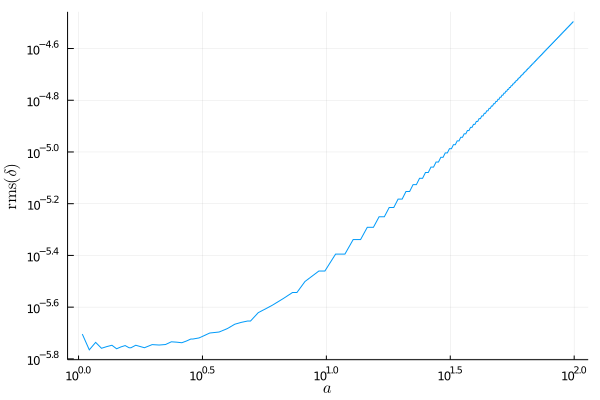

In [24]:
plot(
    summary.a, summary.δx_rms;
    legend=false,
    xlabel=raw"$a$",
    ylabel=raw"$\mathrm{rms}(\delta)$",
    xscale=:log10,
    yscale=:log10,
)

In [25]:
savefig("rms_delta.pdf")

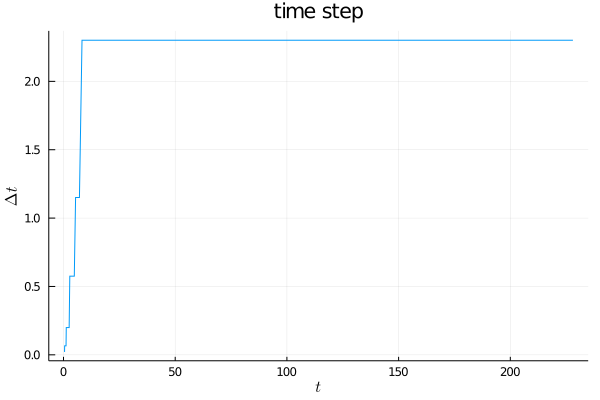

In [26]:
plot(
    summary.t, summary.Δt,
    legend=false,
    title="time step",
    xlabel=raw"$t$",
    ylabel=raw"$\Delta t$",
)

In [27]:
rho_init = npzread("$(output_config.directory)/rho_1.npy");
rho_last = npzread("$(output_config.directory)/rho_$(length(output_times)).npy");

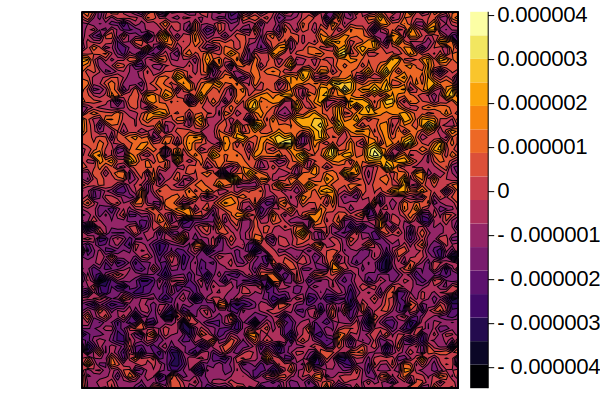

In [28]:
contourf(rho_init[1, :, :] .- 1; aspectratio=:equal, ticks=false)
xlims!(1, resol)

In [29]:
savefig("plane_init.pdf")

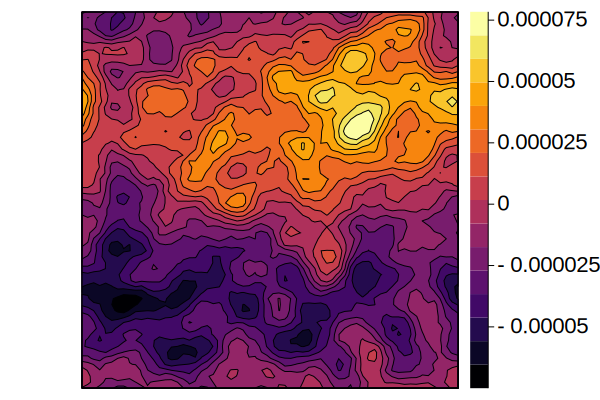

In [30]:
contourf(rho_last[1, :, :] .- 1; aspectratio=:equal, ticks=false)
xlims!(1, resol)

In [31]:
savefig("plane_last.pdf")

In [32]:
lims = extrema(rho_last.-1)

(-9.554365515251906e-5, 0.00010219270948708115)

In [33]:
anim = @animate for i in 1:num_saves
    rho_box = npzread("$(output_config.directory)/rho_$i.npy");
    contourf(
        rho_box[1, :, :] .- 1;
        aspectratio=:equal,
        clims=lims,
        axis=([], false),
        colorbar=:none
    )
end

Animation("/tmp/jl_lhzUpV", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000091.png", "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png"])

┌ Info: Saved animation to 
│   fn = /home/nathan/.julia/dev/JultraDark/examples/tmp.gif
└ @ Plots /home/nathan/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/home/nathan/.julia/dev/JultraDark/examples/tmp.gif")
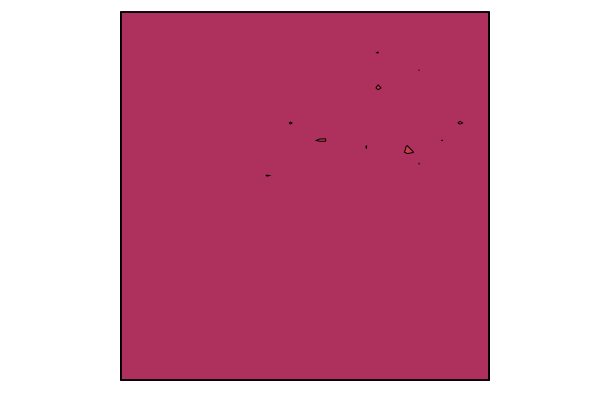

In [34]:
gif(anim, fps=10)

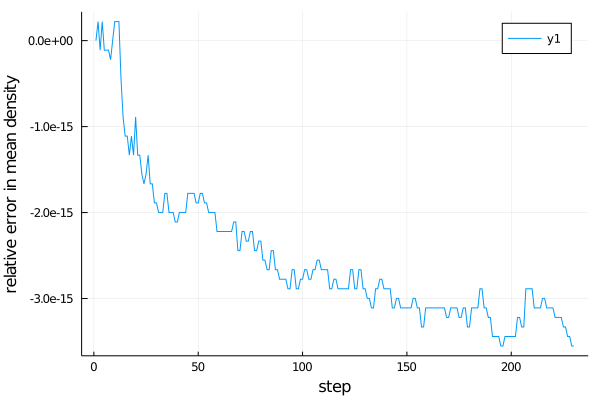

In [35]:
using Printf

plot(
    summary.ρx_mean ./ summary.ρx_mean[1] .- 1,
    xlabel=raw"step",
    ylabel=raw"relative error in mean density",
    yformatter = y->@sprintf("%.1e", y),
)

In [36]:
savefig("error.pdf")